## PV-production forecast analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from casadi import *

In [2]:
data = pd.read_csv("./data_oct20.csv", parse_dates = ["date"])
data = data.iloc[::10].reset_index(drop=True)
data.set_index("date", inplace = True)
data.head(3)

,L2_react,L2,L,L_react,NS4949_export,L2_active_import,PV,Wind_speed,Temperature,Global_irradiance,Plane_irradiance,Module_temp,Bat_current,Bat_energy,Battery_SOC,Battery_voltage,Battery_charge,Battery_discharge,L1
date,,,,,,,,,,,,,,,,,,,
2020-10-01 01:00:00,-1.672253,8.917166,105.823796,-1.330095,103.75,7.500,0.003709,5.0,1.885714,0.017964,0.018072,0.000171,-0.181818,762.249603,69.649998,751.549988,0.000042,0.000031,96.906629
2020-10-01 01:10:00,-1.528216,6.749649,99.311711,1.809572,115.00,5.625,0.037092,3.0,13.221428,0.179641,0.180723,0.001712,-0.714286,761.702393,69.599998,751.555542,0.000416,0.000313,92.562062
2020-10-01 01:20:00,-1.325077,7.088984,106.926927,-0.357718,98.75,7.500,0.074184,4.0,13.292857,0.359281,0.361446,0.003423,-0.769231,762.796814,69.699997,751.549988,0.000832,0.000627,99.837943


In [3]:
solcast_data = pd.read_csv("./solcast_oct.csv", parse_dates = ["PeriodEnd", "PeriodStart"])
solcast_data.drop(["Period"], axis = 1, inplace = True)
solcast_data.set_index("PeriodStart", inplace = True)
solcast_data.index = solcast_data.index.tz_convert(None)
solcast_data.head(2)

,PeriodEnd,AirTemp,Ghi,WindSpeed10m
PeriodStart,,,,
2020-09-30 00:10:00,2020-09-30 00:20:00+00:00,10.8,0,0.6
2020-09-30 00:20:00,2020-09-30 00:30:00+00:00,10.8,0,0.5


In [5]:
df = pd.merge(data, solcast_data, how="inner", left_index=True, right_index =True)

In [6]:
class Photovoltaic:

    # Parameters from Vinod2018
    def __init__(
        self,
        Pm=800,
        Im=8.36,
        Vm=37.38,
        Voc=100,
        Isc=9.06,
        Ns=72,
        A=1.3,
        Ki=0.058,
        Eg=1.1,
    ):
        self.V_value = 0
        self.I_value = 0
        self.Pm = Pm  # Power max at STC
        self.Im = Im  # Current max at STC
        self.Vm = Vm  # Voltage max at STC
        self.Voc = Voc  # Open circuit voltage at STC
        self.Isc = Isc  # Short circuit current
        self.Ns = Ns  # Number of cells connected in series
        self.A = A  # Diode ideality factor
        self.Ki = Ki  # Model constant
        self.Eg = Eg  # Energy band gap
        self.rs = 0  # Equivalent series resistance
        self.rsh = 0  # Shunt resistance
        self.K = 1.3805e-23  # Boltzmann
        self.q = 1.602e-19  # Electron charge
        self.Tref = 298.15  # Ref temp STC of 25C in Kelvin
        self.Gref = 1000  # Ref solar STC

        self.solver = None

        self.estimate()
        self.create_nlp()

    def estimate(self):
        I = SX.sym("I")
        V = SX.sym("V")
        Rs = SX.sym("Rs")
        Rsh = SX.sym("Rsh")

        Irs = SX.sym("Irs")
        Is = SX.sym("Is")
        Iph = SX.sym("Iph")

        Irs = self.Isc / (
            np.exp((self.q * self.Voc) / (self.Ns * self.K * self.A * self.Tref)) - 1
        )
        Is = Irs
        Iph = self.Isc

        g = I - (
            Iph
            - Is
            * (
                np.exp(self.q * (V + I * Rs) / (self.Ns * self.K * self.A * self.Tref))
                - 1
            )
            - (V + I * Rs) / Rsh
        )
        f = power(self.Pm - I * V, 2)

        nlp_prob = {"f": f, "x": vertcat(I, V, Rs, Rsh), "g": g}

        s_opts = {"ipopt": {"print_level": 0}, "print_time": False}

        solver = nlpsol("solver", "ipopt", nlp_prob, s_opts)

        x0 = DM.ones(1, 4)
        lbx = 1e-3 * DM.ones(1, 4)
        ubx = DM([1e3, 1e3, 100, 100])
        lbg = 0
        ubg = 0

        res_nlp = solver(x0=x0, lbx=lbx, ubx=ubx, lbg=lbg, ubg=ubg)

        self.I_value = res_nlp["x"][0]
        self.V_value = res_nlp["x"][1]
        # print(self.V_value, ">V")
        # print(self.I_value, ">I")
        self.rs = res_nlp["x"][2]
        self.rsh = res_nlp["x"][3]

        # print("Estimated: Rs = ", self.rs, " Rsh = ", self.rsh)

    def create_nlp(self):
        I = SX.sym("I")
        V = SX.sym("V")
        T = SX.sym("T")
        G = SX.sym("G")

        Irs = SX.sym("Irs")  # Reverse saturation current
        Is = SX.sym("Is")  # Saturation current
        Iph = SX.sym("Iph")  # Photovoltaic current

        Irs = self.Isc / (
            np.exp((self.q * self.Voc) / (self.Ns * self.K * self.A * T)) - 1
        )
        Is = (
            Irs
            * power(T / self.Tref, 3)
            * np.exp((self.q * self.Eg) / (self.A * self.K) * (1 / self.Tref - 1 / T))
        )
        Iph = G / self.Gref * (self.Isc + self.Ki * (T - self.Tref))

        g = I - (
            Iph
            - Is
            * (np.exp(self.q * (V + I * self.rs) / (self.Ns * self.K * self.A * T)) - 1)
        )  # - (V + I * self.rs)/self.rsh)
        f = -I * V

        nlp_prob = {"f": f, "x": vertcat(I, V), "g": g, "p": vertcat(T, G)}

        s_opts = {"ipopt": {"print_level": 0}, "print_time": False}

        self.solver = nlpsol("solver", "ipopt", nlp_prob, s_opts)

    def solve_prob(self, T, G):
        x0 = DM([0, 0])
        lbx = DM([0, 0])
        ubx = DM([1e3, 1e3])
        lbg = 0
        ubg = 0
        param = vertcat(273.15 + T, G)

        res_nlp = self.solver(x0=x0, lbx=lbx, ubx=ubx, lbg=lbg, ubg=ubg, p=param)
        self.I_value = res_nlp["x"][0]
        self.V_value = res_nlp["x"][1]
        # print(self.V_value, "her")
        # print(self.I_value, "heri")

        # print("Power:", self.V_value * self.I_value)
        return (self.V_value * self.I_value).full().flatten()[0]

    def predict(self, T, G):
        assert len(T) == len(G)
        return np.asarray([self.solve_prob(T[i], G[i]) for i in range(len(T))])



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



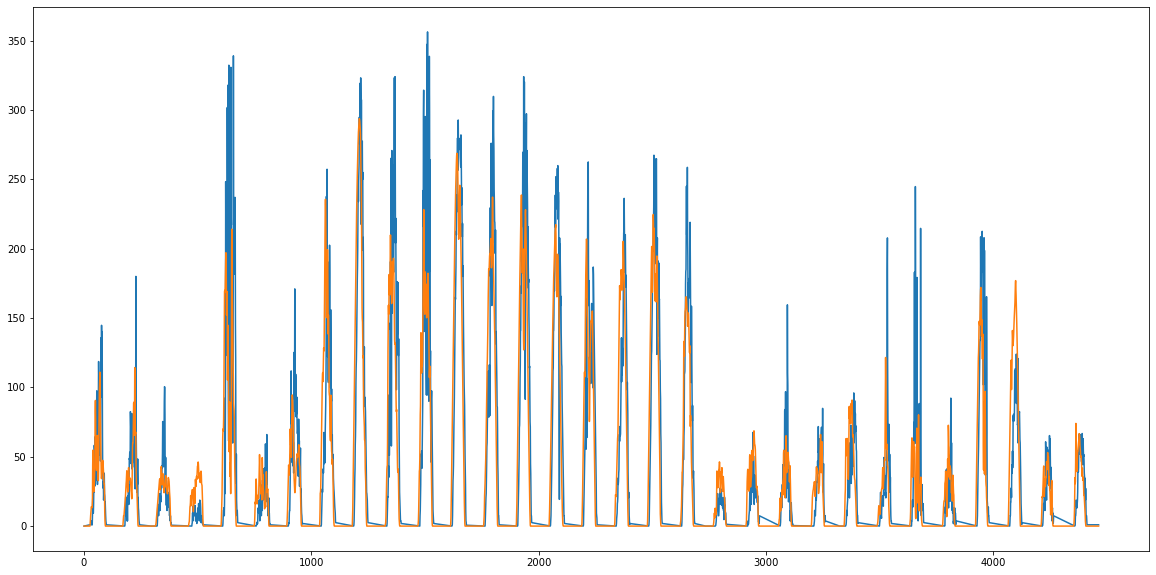

In [7]:
PV = Photovoltaic()
num_steps = 1000
data_red = df.copy() # iloc[500:num_steps]
pv_output = PV.predict(data_red["AirTemp"], data_red["Ghi"])

df["PV_pred"] = pv_output
plt.figure(figsize= (20, 10))
plt.plot(range(data_red.shape[0]), data_red.PV)
plt.plot(range(data_red.shape[0]), pv_output)

In [8]:
def rmse(y_true, y_pred):
    return np.sqrt(((y_pred - y_true) ** 2).mean())

In [9]:
print("Root mean squared error")
print("PV Production:", rmse(df["PV"], df["PV_pred"]))
print("Temperature:", rmse(df["Temperature"], df["AirTemp"]))
print("GHI:", rmse(df["Global_irradiance"], df["Ghi"]))

Root mean squared error
PV Production: 36.0542643154387
Temperature: 2.0642892364097563
GHI: 48.06059996128383


In [10]:

df["errors"] = np.around(df["PV"] - df["PV_pred"])
df["errors"].mean()

1.502464157706093

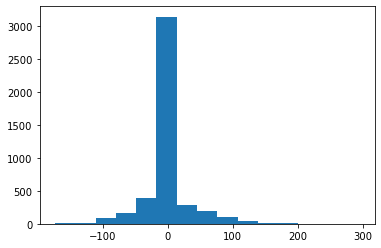

In [11]:
plt.hist(df.errors, bins = 15)
plt.show()